# Meta-atom RCWA model with optimization 

Geometry of a meta-atom:

<img src="meta-atom-crossection.png" width="400">

Requirements:

- Python: >=3.9
- NumPy        
- gRCWA: 0.1.2 [https://github.com/weiliangjinca/grcwa]
- NLOpt: 2.7.1 [https://github.com/stevengj/nlopt]
- scikit-image: 0.20 [https://scikit-image.org/]

Conda environment setup:
```
$ conda create -n rcwa python=3.10
$ conda activate rcwa
$ conda update conda --all
$ conda install -c conda-forge blas='*=*mkl*' libblas='*=*mkl*' libcblas='*=*mkl*' liblapack='*=*mkl*'
$ conda install -c conda-forge numpy matplotlib scipy nlopt scikit-image
$ pip install grcwa
```

## imports & basic functions definition

In [1]:
import sys
import numpy as np
import grcwa
import nlopt
from skimage.transform import rotate
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
def grad_numpy(func):
    '''
    A NumPy-based wrapper for calculating gradients.
    
    /  f(x1+dx1)) - f(x1-dx1)       f(xN+dxN)) - f(xN-dxN) \
    | ----------------------, ..., ----------------------  |
    \           2*dx1                        2*dxN         /
    
    Example of usage:
    >>> func_grad = grad(func)
    >>> func_grad(x, dxs)
    '''
    
    def wrapper(x, dxs, dtype=float):
        n = len(x)
        gradn = np.zeros(n, dtype=dtype)
        
        # the same dx_i for all partial derivatives
        if isinstance(dxs,float) or isinstance(dxs,int):
            dxs = np.ones(len(x))*dxs
        elif len(dxs) != n:
            raise(f'Lendth of dxs vector should be equal to {n}, or define dxs as a scalar value.')
        
        for i in range(n):
            args_p = np.hstack([x[:i], x[i]+dxs[i], x[i+1:]])
            args_m = np.hstack([x[:i], x[i]-dxs[i], x[i+1:]])
            gradn[i] = (func(args_p) - func(args_m)) / (2*dxs[i])
        
        return gradn
                                                        
    return wrapper

def pillar_mask_gen(X, Y, length, width, x0, y0):
    '''
    This function returns binary mask for a rectangle with (length,width) sides in (x0,y0) coords
    on a defined (X,Y) grid.
    '''
    
    return np.logical_and(np.abs(X-x0) <= 0.5*length, np.abs(Y-y0) <= 0.5*width)

def coords_rotate(x0, y0, rot_angle_deg):
    '''
    This fuction rotate input (x0,y0) coords on a defined angle in CCW direction. New coords are returned. 
    '''
    
    rot_angle_rad = rot_angle_deg*np.pi/180
    
    x0_new = x0*np.cos(-rot_angle_rad) - y0*np.sin(-rot_angle_rad)
    y0_new = x0*np.sin(-rot_angle_rad) + y0*np.cos(-rot_angle_rad)
    
    return x0_new, y0_new

def draw_progress_bar(progress, bar_len=20):
    '''
    This function draws simple updatable progress bar. Progress parameter takes values in the range of [0,1].
    
    Based on: https://stackoverflow.com/questions/3002085/how-to-print-out-status-bar-and-percentage
    '''
    
    if  0 <= progress <= 1:
        sys.stdout.write('\r')
        sys.stdout.write('[{:<{}}] {:.2%}'.format('='*int(bar_len*progress), bar_len, progress))
        sys.stdout.flush()
    else:
        raise ValueError('Incorrect input value.')

In [3]:
GRCWA_BACKEND = 'numpy'
grcwa.set_backend(GRCWA_BACKEND)

if GRCWA_BACKEND == 'numpy':
    import numpy as npa
    grad = grad_numpy
# elif GRCWA_BACKEND == 'autograd':
#     import autograd.numpy as npa
#     from autograd import grad
# elif GRCWA_BACKEND == 'jax':
#     import jax.numpy as npa
#     from jax import grad

## initial parameters

In [4]:
nG_max = 200 # maximum number Fourier expansion orders to use in XY plane

# cell size & grid
a = 8          # cell size along x and y axes
Nx = Ny = 1601 # points along x and y axes
dxs = a/(Nx-1) # spatial resolution in um

x = np.linspace(-0.5*a, 0.5*a, Nx)
y = np.linspace(-0.5*a, 0.5*a, Ny)
X, Y = np.meshgrid(x, y) # X,Y mesh

# materials
epsSi  = 3.44**2  # Si
epsAir = 1.0      # Air

# thicknesses of layers
thickSiSubstrateUniform  = 2.50 # Si substrate
thickSiPillarsGrid       = 7.50 # Si rectangular pillars
thickAirGrid             = 12   # Air gap, grid,    !!! grid layer is needed to extract e-field distributions
thickAirUniform          = 12   # Air gap, uniform, !!! uniform layer is needed to extract mode amplitudes

thickTotal = thickSiSubstrateUniform + thickSiPillarsGrid + thickAirGrid

# radiation params
lam = 12                  # wavelength 
freq = 1.0/lam + 1j*1e-20 # small imaginary part is to avoid singular matrix

phi = 0.0   # polar angle phi in [0,180)
phi_rad = phi * np.pi/180
theta = 0.0 # azimuthal angle theta in [0,360)
theta_rad = theta * np.pi/180

# P-polarized wave (electric field along x axis if normally incident planewave)
P_wave = {
    'p_amp':     1.0,
    'p_phase':   0.0,
    's_amp':     0.0,
    's_phase':   0.0,
    'order':     0,
    'direction': 'forward'
}

# S-polarized wave (electric field along y axis if normally incident planewave)
S_wave = {
    'p_amp':     0.0,
    'p_phase':   0.0,
    's_amp':     -1.0, # negative sign is for initial phase zeroing while simulations
    's_phase':   0.0,
    'order':     0,
    'direction': 'forward'
}

# # left-circularly polarized wave
# LCP_wave = {
#     'p_amp':     1. / np.sqrt(2),
#     'p_phase':   0.0,
#     's_amp':     -1j / np.sqrt(2),
#     's_phase':   0.0,
#     'order':     0,
#     'direction': 'forward'
# }

# # right-circularly polarized wave
# RCP_wave = {
#     'p_amp':     1. / np.sqrt(2),
#     'p_phase':   0.0,
#     's_amp':     1j / np.sqrt(2),
#     's_phase':   0.0,
#     'order':     0,
#     'direction': 'forward'
# }

## test: masks generator for rectangular pillars

Text(0, 0.5, 'y (um)')

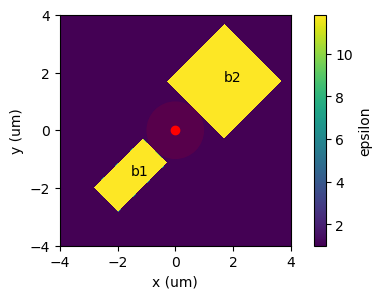

In [5]:
# test params: pillars length, width, and grid rotation angle
p1_params_test = {'length': 2.4, 'width': 1.2, 'x0': -2.2, 'y0': 0.0} # left-handed pillar
p2_params_test = {'length': 2.8, 'width': 2.8, 'x0':  2.4, 'y0': 0.0} # right-handed pillar
rot_angle_deg = -45

# epsilon grid definition and rotation
epgrid_test = np.ones((Nx,Ny), dtype=float)*epsAir
epgrid_test[pillar_mask_gen(X,Y,**p1_params_test)] = epsSi
epgrid_test[pillar_mask_gen(X,Y,**p2_params_test)] = epsSi
epgrid_test = rotate(epgrid_test, angle=rot_angle_deg, mode='edge')

# center coords rotation
p1_x0, p1_y0 = coords_rotate(p1_params_test['x0'], p1_params_test['y0'], rot_angle_deg)
p2_x0, p2_y0 = coords_rotate(p2_params_test['x0'], p2_params_test['y0'], rot_angle_deg)

fig, ax = plt.subplots(1,1,figsize=(6,3))
c = ax.pcolormesh(x, y, epgrid_test)
fig.colorbar(c, ax=ax, label='epsilon')
ax.plot([0], [0], 'ro')
ax.text(p1_x0, p1_y0, 'b1', color='black')
ax.text(p2_x0, p2_y0, 'b2', color='black')
ax.add_patch(plt.Circle((0, 0), 1.0, color='r', alpha=0.1, lw=0))
ax.set_aspect('equal')
ax.set_xlabel('x (um)')
ax.set_ylabel('y (um)')

## test: basic model, power conservation (reflection + transmission)

In [6]:
obj = grcwa.obj(nG=nG_max, L1=[a,0.], L2=[0.,a], freq=freq, theta=theta_rad, phi=phi_rad, verbose=1)

obj.Add_LayerUniform(thickSiSubstrateUniform, epsSi) # Substrate,         layer no. 0, z =  0.00 - 2.50  um -  0.00 is input plane
obj.Add_LayerGrid(thickSiPillarsGrid, Nx, Ny)        # Rect. pillars,     layer no. 1, z =  2.50 - 10.00 um
obj.Add_LayerGrid(thickAirGrid, Nx, Ny)              # Air gap with grid, layer no. 2, z = 10.00 - 22.00 um - 22.00 is ex/ey extraction plane
obj.Add_LayerUniform(0, epsAir)                      # Air gap unifrom,   layer no. 3, z = 22.00 - 22.00 um - 22.00 is amps extraction plane

obj.Init_Setup(Gmethod=0) # Gmethod=0 for circular, 1 for rectangular

obj.MakeExcitationPlanewave(**P_wave)

# patterning of the "Rect. pillars" layer 
obj.GridLayer_geteps(np.concatenate([epgrid_test.flatten(), np.ones(Nx*Ny)*epsAir]))

# excited forward/backward modes
print('Complex ampitude & phase for excited 0-th order modes:',
      '--------------------------------------',
      f's-pol fwd: {obj.a0[0]:>15.3f} {np.angle(obj.a0[0])/np.pi:5.2f} π',
      f'p-pol fwd: {obj.a0[obj.nG]:>15.3f} {np.angle(obj.a0[obj.nG])/np.pi:5.2f} π',
      f's-pol bwd: {obj.bN[0]:>15.3f} {np.angle(obj.bN[0])/np.pi:5.2f} π',
      f'p-pol bwd: {obj.bN[obj.nG]:>15.3f} {np.angle(obj.bN[obj.nG])/np.pi:5.2f} π',
      sep='\n')

Total nG =  197
Complex ampitude & phase for excited 0-th order modes:
--------------------------------------
s-pol fwd:    0.000+0.000j  0.00 π
p-pol fwd:    1.000+0.000j  0.00 π
s-pol bwd:    0.000+0.000j  0.00 π
p-pol bwd:    0.000+0.000j  0.00 π


In [7]:
# solve for R and T
refl_test, tran_test = obj.RT_Solve(normalize=1)
print(f'R = {refl_test:.5f}\nT = {tran_test:.5f}\nTotal power: {refl_test+tran_test:.5f}')

R = 0.54364
T = 0.45636
Total power: 1.00000


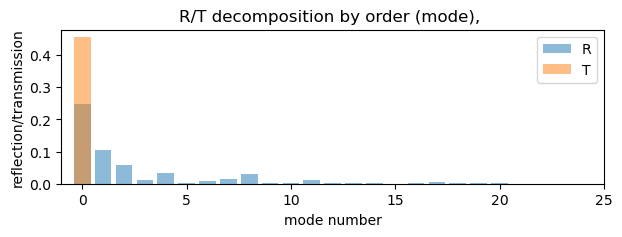

In [8]:
# solve for R and T by order
refl_byorder_test, tran_byorder_test = obj.RT_Solve(normalize=1, byorder=1)

N_modes = 25

fig, ax = plt.subplots(1,1,figsize=(7,2))

ax.bar(np.arange(N_modes), refl_byorder_test[:N_modes], alpha=0.5, label='R')
ax.bar(np.arange(N_modes), tran_byorder_test[:N_modes], alpha=0.5, label='T')

ax.set_title(f'R/T decomposition by order (mode), ')
ax.set_xlabel('mode number')
ax.set_ylabel('reflection/transmission')
ax.set_xlim([-1, N_modes])
ax.legend()

In [9]:
refl_byorder_test.sum(), tran_byorder_test.sum()

(0.5436406260947018, 0.45635937390533443)

## test: reconstruction of epsilon and electric field components from Fourier series

Text(0, 0.5, 'y (um)')

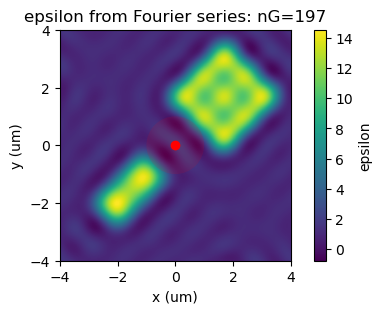

In [10]:
# z = thickSiSubstrate + thickSiPillarsGrid

eps_test = obj.Return_eps(which_layer=1, Nx=Nx, Ny=Ny, component='xx')

fig, ax = plt.subplots(1,1,figsize=(6,3))
c0 = ax.pcolormesh(x, y, eps_test[::-1,::-1].real)
fig.colorbar(c0, ax=ax, label='epsilon')
ax.plot([0], [0], 'ro')
ax.add_patch(plt.Circle((0, 0), 1.0, color='r', alpha=0.1, lw=0))
ax.set_aspect('equal')
ax.set_title(f'epsilon from Fourier series: nG={obj.nG}')
ax.set_xlabel('x (um)')
ax.set_ylabel('y (um)')

## test: reconstruction of electric field components from Fourier series

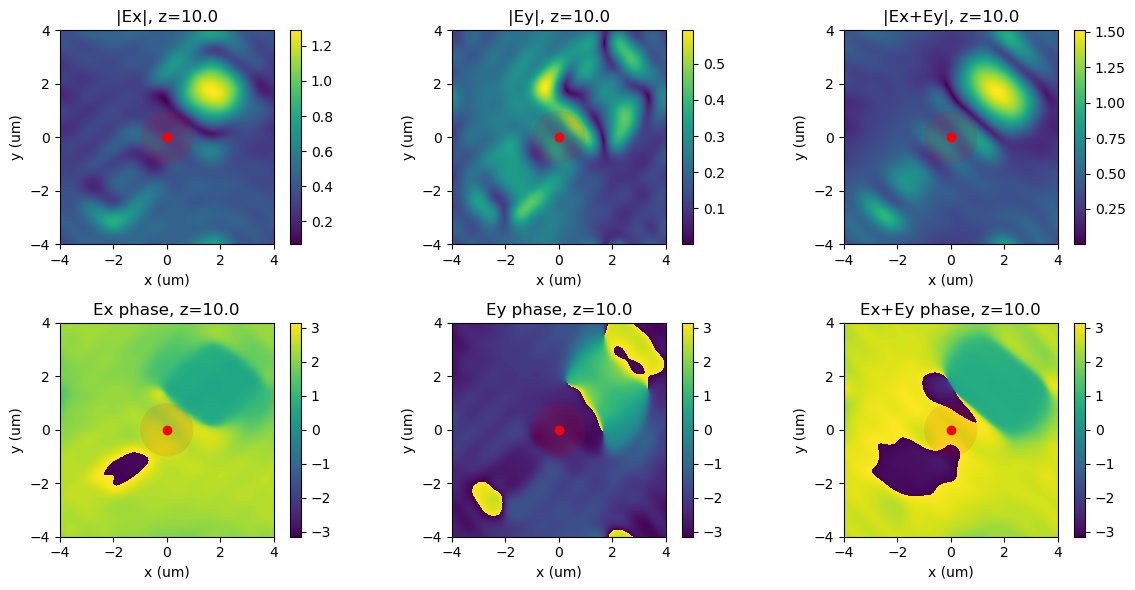

In [11]:
# z = thickSiSubstrate + thickSiPillarsGrid

(ex_test,ey_test,_), (_,_,_) = obj.Solve_FieldOnGrid(which_layer=2, z_offset=0)
z_shift = thickSiSubstrateUniform + thickSiPillarsGrid

# fields to be plotted
fields = [ex_test, ey_test, ex_test+ey_test]
fields_abs = [np.abs(e) for e in fields]
fields_phase = [np.angle(e) for e in fields]
labels = ('Ex', 'Ey', 'Ex+Ey')

fig, axs = plt.subplots(2,3,figsize=(12,6))

# absolute values of e-field components
for ax, fa, l in zip(axs[0,:], fields_abs, labels):
    c = ax.pcolormesh(x, y, fa)
    fig.colorbar(c, ax=ax)
    ax.set_title(f'|{l}|, z={z_shift}')
    ax.plot([0], [0], 'ro')
    ax.add_patch(plt.Circle((0, 0), 1.0, color='r', alpha=0.1, lw=0))
    ax.set_aspect('equal')
    ax.set_xlabel('x (um)')
    ax.set_ylabel('y (um)')
    
# phases of e-field components
for ax, fp, l in zip(axs[1,:], fields_phase, labels):
    c = ax.pcolormesh(x, y, fp)
    fig.colorbar(c, ax=ax)
    ax.set_title(f'{l} phase, z={z_shift}')
    ax.plot([0], [0], 'ro')
    ax.add_patch(plt.Circle((0, 0), 1.0, color='r', alpha=0.1, lw=0))
    ax.set_aspect('equal')
    ax.set_xlabel('x (um)')
    ax.set_ylabel('y (um)')
    
fig.tight_layout()

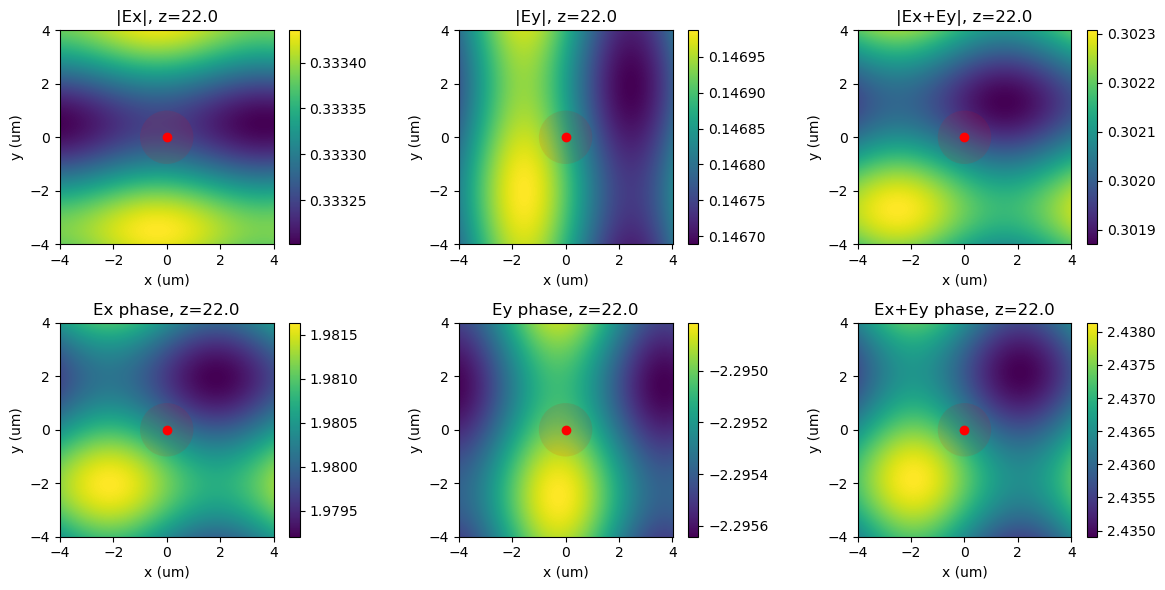

In [12]:
# z = thickSiSubstrate + thickSiPillarsGrid + thickAirGrid

(ex_test,ey_test,_), (_,_,_) = obj.Solve_FieldOnGrid(which_layer=2, z_offset=thickAirGrid)
z_shift = thickSiSubstrateUniform + thickSiPillarsGrid + thickAirGrid

# fields to be plotted
fields = [ex_test, ey_test, ex_test+ey_test]
fields_abs = [np.abs(e) for e in fields]
fields_phase = [np.angle(e) for e in fields]
labels = ('Ex', 'Ey', 'Ex+Ey')

fig, axs = plt.subplots(2,3,figsize=(12,6))

# absolute values of e-field components
for ax, fa, l in zip(axs[0,:], fields_abs, labels):
    c = ax.pcolormesh(x, y, fa)
    fig.colorbar(c, ax=ax)
    ax.set_title(f'|{l}|, z={z_shift}')
    ax.plot([0], [0], 'ro')
    ax.add_patch(plt.Circle((0, 0), 1.0, color='r', alpha=0.1, lw=0))
    ax.set_aspect('equal')
    ax.set_xlabel('x (um)')
    ax.set_ylabel('y (um)')
    
# phases of e-field components
for ax, fp, l in zip(axs[1,:], fields_phase, labels):
    c = ax.pcolormesh(x, y, fp)
    fig.colorbar(c, ax=ax)
    ax.set_title(f'{l} phase, z={z_shift}')
    ax.plot([0], [0], 'ro')
    ax.add_patch(plt.Circle((0, 0), 1.0, color='r', alpha=0.1, lw=0))
    ax.set_aspect('equal')
    ax.set_xlabel('x (um)')
    ax.set_ylabel('y (um)')
    
fig.tight_layout()

## test: mode amplitudes 

In [13]:
# z = 0 plane
a0_test, b0_test = obj.GetAmplitudes(which_layer=0, z_offset=0) # returns complex amp. for (s-pol fwd, p-pol fwd, s-pol bwd, p-pol bwd)
print('initial abs. amplitudes of s- and p- fwd modes: ', np.abs([a0_test[0], a0_test[obj.nG]])) # ! 0th order
print('initial phases of s- and p- fwd modes: ', np.angle([a0_test[0], a0_test[obj.nG]])) # ! 0th order

initial abs. amplitudes of s- and p- fwd modes:  [0. 1.]
initial phases of s- and p- fwd modes:  [0. 0.]


In [14]:
# z = thickSiSubstrate plane
ai_test, bi_test = obj.GetAmplitudes(which_layer=0, z_offset=thickSiSubstrateUniform)
print(f's- and p- amplitudes after passing substrate: ', np.abs([ai_test[0],ai_test[obj.nG]]))
print('s- and p- phases after passing substrate:', np.angle([ai_test[0],ai_test[obj.nG]]), ' rad')

s- and p- amplitudes after passing substrate:  [0. 1.]
s- and p- phases after passing substrate: [-0.         -1.78023584]  rad


In [15]:
# let us compare with analytical solution
k_sub = np.exp(1j*2*np.pi*np.sqrt(epsSi)*thickSiSubstrateUniform/lam)
print(f'phase extracted from wavevector after passing substrate: {np.angle(k_sub):.5f} rad')

phase extracted from wavevector after passing substrate: -1.78024 rad


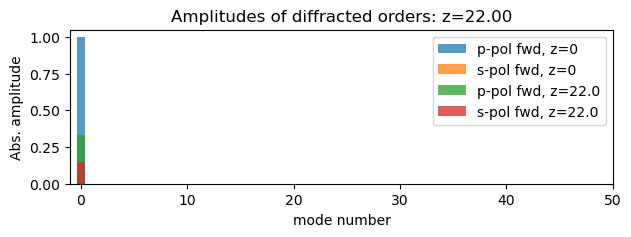

In [16]:
# z = thickTotal plane
ai_test, bi_test = obj.GetAmplitudes(which_layer=3, z_offset=0)
z_shift = thickSiSubstrateUniform + thickSiPillarsGrid + thickAirGrid

fig, ax = plt.subplots(1,1,figsize=(7,2))

ax.bar(np.arange(obj.nG), np.abs(a0_test[obj.nG:]), alpha=0.75, label='p-pol fwd, z=0')
ax.bar(np.arange(obj.nG), np.abs(a0_test[:obj.nG]), alpha=0.75, label='s-pol fwd, z=0')
ax.bar(np.arange(obj.nG), np.abs(ai_test[obj.nG:]), alpha=0.75, label=f'p-pol fwd, z={thickTotal}')
ax.bar(np.arange(obj.nG), np.abs(ai_test[:obj.nG]), alpha=0.75, label=f's-pol fwd, z={thickTotal}')

ax.set_title(f'Amplitudes of diffracted orders: z={z_shift:.2f}')
ax.set_xlabel('mode number')
ax.set_ylabel('Abs. amplitude')
ax.set_xlim([-1, 50])
ax.legend()

In [17]:
# ex/ey components taken in the center of output plane

ex_c_test = ex_test[Nx//2,Ny//2]
ey_c_test = ey_test[Nx//2,Ny//2]

print(ex_c_test, ey_c_test)
print(np.angle([ex_c_test, ey_c_test]))

(-0.13270126823127895+0.3056948771762063j) (-0.09731394579844965-0.11001713455213949j)
[ 1.98034702 -2.29500092]


In [18]:
# p0/s0 amplitudes taken in the output plane

a_s0_test = ai_test[0]
a_p0_test = ai_test[obj.nG]

print(a_p0_test, a_s0_test)
print(np.angle([a_p0_test, a_s0_test]))

(-0.13275030291343723+0.30574242156957776j) (0.09731152838615068+0.10996364792841239j)
[1.98042517 0.84636273]


## main: function definition

In [19]:
def metaatom_grcwa(x, gap, rot_angle_deg, freq, planewave_params, return_amps_only=False, debug=False):
    '''
    This function constructs RCWA model for a two-rectangular pillat meta-atom and calculates complex amplitudes
    and reflection/transmission coefficients at the output.
    
       (output)
    ______________ z = thickSiSubstrate + thickSiPillars + thickAirUniform
    
       __    __ __ z = thickSiSubstrate + thickSiPillarsGrid
      |  |  |  |
      |p1|  |p2|
    __|__|__|__|__ z = thickSiSubstrateUniform 
    ______________ z = 0.00
    ^^^^^^^^^^^^^^
       (input)
       
    If return_amps_only is 'True', the function returns (amp_s0_out, amp_p0_out) complex amplitudes.
    If return_amps_only is 'False', the function returns complex amplitudes and reflection/transmission
    coefficients (amp_s0_out, amp_p0_out, R, T).
    
    '''
    
    l1, w1, l2, w2 = x # unpacking lengths/widths of trectangular pillars
    
    xc_gap1 = -0.5*gap # distance from center to left-handed pillar #1 edge
    xc_gap2 =  0.5*gap # distance from center to right-handed pillar #2 edge
    
    p1_params = {'length': l1, 'width': w1, 'x0': xc_gap1+np.sign(xc_gap1)*0.5*l1, 'y0': 0.0} # left-handed pillar
    p2_params = {'length': l2, 'width': w2, 'x0': xc_gap2+np.sign(xc_gap2)*0.5*l2, 'y0': 0.0} # right-handed pillar
    
    obj = grcwa.obj(nG=nG_max, L1=[a,0.], L2=[0.,a], freq=freq, theta=theta_rad, phi=phi_rad, verbose=0)

    obj.Add_LayerUniform(thickSiSubstrateUniform, epsSi) # Substrate,       layer no. 0
    obj.Add_LayerGrid(thickSiPillarsGrid, Nx, Ny)         # Rect. pillars,    layer no. 1
    obj.Add_LayerUniform(thickAirUniform, epsAir)        # Air gap uniform, layer no. 2
    
    obj.Init_Setup(Gmethod=0) # Gmethod=0 for circular, 1 for rectangular

    # patterning of the "Rect. pillars" layer 
    epgrid = npa.ones((Nx,Ny), dtype=float)*epsAir
    epgrid[pillar_mask_gen(X,Y,**p1_params)] = epsSi
    epgrid[pillar_mask_gen(X,Y,**p2_params)] = epsSi
    epgrid = rotate(epgrid, rot_angle_deg, mode='edge')
    
    # debug info
    if debug:
        
        # center coords rotation
        p1_x0, p1_y0 = coords_rotate(p1_params['x0'], p1_params['y0'], rot_angle_deg)
        p2_x0, p2_y0 = coords_rotate(p2_params['x0'], p2_params['y0'], rot_angle_deg)

        title_text = 'b1: l={length:.2f}, w={width:.2f}, center=({x0:.2f}, {y0:.2f})\n'.format(**p1_params) +\
                     'b2: l={length:.2f}, w={width:.2f}, center=({x0:.2f}, {y0:.2f})\n'.format(**p2_params) +\
                     'angle of rotation: {:d} degrees'.format(rot_angle_deg)
        
        # epsilon plotting
        fig, ax = plt.subplots(1, 1, figsize=(8,4))
        c = ax.pcolormesh(X, Y, epgrid)
        fig.colorbar(c, ax=ax, label='epsilon')
        ax.set_title(title_text, loc='left')
        ax.plot([0], [0], 'ro')
        ax.add_patch(plt.Circle((0, 0), 1.0, color='r', alpha=0.1, lw=0))
        ax.text(p1_x0, p1_y0, 'b1', color='black')
        ax.text(p2_x0, p2_y0, 'b2', color='black')
        ax.set_aspect('equal')
        ax.set_xlabel('x (um)')
        ax.set_ylabel('y (um)')
    
    obj.GridLayer_geteps(np.concatenate([epgrid.flatten(),np.ones(Nx*Ny)*epsAir]))

    obj.MakeExcitationPlanewave(**planewave_params)
    
    # 0-th diffraction order amplitudes after passing Air gap
    ai, _ = obj.GetAmplitudes(which_layer=2, z_offset=thickAirUniform) # returns ai, bi
    ai_s0 = ai[0]       # s-polarization
    ai_p0 = ai[obj.nG]  # p-polarization
    
    if return_amps_only:
        return ai_s0, ai_p0
    else:
        refl, tran = obj.RT_Solve(normalize=1) # solve for R and T
        return ai_s0, ai_p0, refl, tran

a_s0  = 0.097+0.110j
a_p0  = -0.133+0.306j
R     = 0.544
T     = 0.456


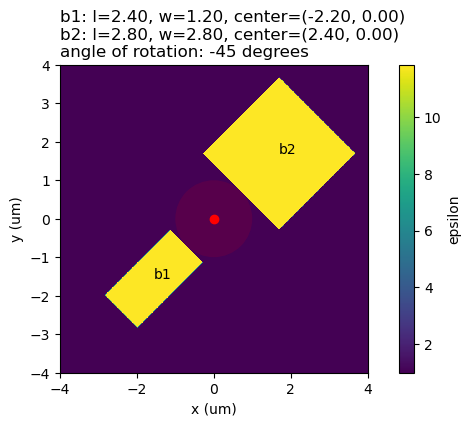

In [20]:
x_test = [2.4, 1.2, 2.8, 2.8]
gap_test = 2
rot_angle_deg_test = -45

res_test = metaatom_grcwa(x=x_test, gap=gap_test, rot_angle_deg=rot_angle_deg_test, freq=freq, planewave_params=P_wave, debug=True)
res_labels = ('a_s0','a_p0','R','T')
res_output_str = '\n'.join([f'{l:5} = {val:.3f}' for l, val in zip(res_labels, res_test)])
print(res_output_str)

## main: 8-12 um transmission spectrum & phase response

In [21]:
# here we calculate transmission and phase response for a meta-atom similar to used in Fig. 1 in ref. APL [https://doi.org/10.1063/5.0120717]

x = [2.0, 1.4, 1.6, 2.4] # ref. APL geometry
gap = 2 # gap between rect. pillars

# wavelength range
lam_range = np.linspace(8, 12, 41)
freq_range = 1./lam_range + 1j*1e-20
Nfreq = len(freq_range)

res_labels = ('a_s0','a_p0','R','T')
Nres = len(res_labels)

res_p_pol_45deg  = np.zeros((Nfreq,Nres), dtype=complex)
res_s_pol_45deg  = np.zeros((Nfreq,Nres), dtype=complex)
res_p_pol_135deg = np.zeros((Nfreq,Nres), dtype=complex)
res_s_pol_135deg = np.zeros((Nfreq,Nres), dtype=complex)

for i, freq in enumerate(freq_range):
    
    res_p_pol_45deg [i,:] = metaatom_grcwa(x, gap=gap, rot_angle_deg=-45,  freq=freq, planewave_params=P_wave)
    res_s_pol_45deg [i,:] = metaatom_grcwa(x, gap=gap, rot_angle_deg=-45,  freq=freq, planewave_params=S_wave)
    res_p_pol_135deg[i,:] = metaatom_grcwa(x, gap=gap, rot_angle_deg=-135, freq=freq, planewave_params=P_wave)
    res_s_pol_135deg[i,:] = metaatom_grcwa(x, gap=gap, rot_angle_deg=-135, freq=freq, planewave_params=S_wave)
 
    draw_progress_bar((i+1)/Nfreq)

[====================] 100.00%

### data loading

In [22]:
# MEEP: transmission
wl_range_tran_meep = np.array([12.000000000000004, 11.939698492462314, 11.880000000000003, 11.820895522388064, 11.762376237623764, 11.704433497536948, 11.647058823529415, 11.590243902439028, 11.533980582524274, 11.47826086956522, 11.423076923076925, 11.36842105263158, 11.314285714285717, 11.260663507109006, 11.207547169811322, 11.154929577464792, 11.10280373831776, 11.051162790697676, 11.000000000000002, 10.94930875576037, 10.89908256880734, 10.849315068493153, 10.800000000000002, 10.75113122171946, 10.702702702702704, 10.654708520179373, 10.60714285714286, 10.560000000000002, 10.513274336283187, 10.466960352422909, 10.421052631578949, 10.375545851528384, 10.330434782608696, 10.285714285714286, 10.24137931034483, 10.197424892703864, 10.153846153846155, 10.110638297872342, 10.067796610169493, 10.025316455696203, 9.983193277310926, 9.94142259414226, 9.900000000000002, 9.858921161825727, 9.818181818181818, 9.777777777777779, 9.737704918032788, 9.69795918367347, 9.658536585365855, 9.619433198380568, 9.580645161290322, 9.542168674698795, 9.504000000000001, 9.466135458167331, 9.428571428571429, 9.391304347826086, 9.354330708661418, 9.31764705882353, 9.28125, 9.245136186770429, 9.209302325581396, 9.173745173745175, 9.138461538461538, 9.10344827586207, 9.068702290076336, 9.034220532319392, 9.0, 8.966037735849056, 8.93233082706767, 8.898876404494382, 8.865671641791044, 8.832713754646841, 8.8, 8.767527675276753, 8.73529411764706, 8.703296703296704, 8.671532846715328, 8.64, 8.608695652173914, 8.577617328519857, 8.546762589928058, 8.516129032258064, 8.485714285714286, 8.455516014234876, 8.425531914893616, 8.395759717314487, 8.366197183098592, 8.336842105263159, 8.307692307692307, 8.278745644599304, 8.25, 8.221453287197232, 8.193103448275862, 8.164948453608247, 8.136986301369863, 8.109215017064846, 8.081632653061225, 8.054237288135592, 8.027027027027026, 8.0])
tran_meep_res15 = np.array([0.6995778408710563, 0.6943778673785804, 0.6671427721123752, 0.654713298115344, 0.6546177425693358, 0.6405075084380882, 0.6099175481093204, 0.5775254549344393, 0.5453747672145474, 0.5061919075141276, 0.4624256936217557, 0.42459307961331405, 0.3974205099965513, 0.3776954652118776, 0.3620682830152295, 0.3505286254733625, 0.3435609703910426, 0.33995704673600774, 0.3381645405609018, 0.33828719456947387, 0.3416137584432094, 0.34840599476546225, 0.35746685841229536, 0.3682160427897796, 0.38146294506015693, 0.39713368703497903, 0.41298112179444807, 0.4268468830459444, 0.43842051468082016, 0.4473751226891005, 0.45194193977658537, 0.45137942246466484, 0.44799534068618785, 0.4445921692373909, 0.44167080625755883, 0.43917535699051785, 0.43870572200943286, 0.4411995218611458, 0.44445625413761264, 0.4460974574693108, 0.4469780837802547, 0.4480432623070298, 0.4460914675490893, 0.4379801544769211, 0.4281270252705685, 0.4255951514265887, 0.43239149904446766, 0.4400838574278499, 0.4404900630346283, 0.43510059759694597, 0.4307849067240365, 0.43040041385119976, 0.4320495361136241, 0.4347166345050088, 0.4394602550809537, 0.4458235532903523, 0.4513390101206324, 0.4547554652388416, 0.45663617023563774, 0.45674256154469883, 0.45371599332375306, 0.4475850322830755, 0.4400736278878084, 0.4321546070313108, 0.42348229167204954, 0.41430038687405896, 0.4056350210240854, 0.397387029986865, 0.3882940799729222, 0.37788456194174397, 0.3664944051425651, 0.35344945638618785, 0.3373349361030286, 0.3179804674764742, 0.2962635936432184, 0.27257452948905897, 0.24789888481816347, 0.22586079168119966, 0.21118614761100923, 0.20672381591021033, 0.21388227110322827, 0.23363349732291305, 0.26344472626581683, 0.2954300657308402, 0.3219196657054729, 0.340956895109608, 0.35275689510491587, 0.35523893660352934, 0.34868101835770976, 0.33922961186138506, 0.33045393292111624, 0.31803902937347267, 0.30103324124080166, 0.2883451919552708, 0.2831975714694581, 0.2754296843225956, 0.2647784304829741, 0.2728479264663823, 0.30975210995373104, 0.35171400394441893])
tran_meep_res40 = np.array([0.681052695853627, 0.6792326596041909, 0.6863053772437996, 0.6699200715329807, 0.6479557456522514, 0.6371651012295351, 0.6205650484759699, 0.5864028445988987, 0.5454616445525555, 0.5058995743487015, 0.4655965008975581, 0.4267016829570773, 0.3962735804941122, 0.37566714103803694, 0.3606553078123655, 0.3488372761011231, 0.34083592296919624, 0.3365782838072887, 0.33451872562424695, 0.33416311298323537, 0.33675306201592387, 0.342836108791934, 0.35130151762386147, 0.3617033073362004, 0.37496163247378606, 0.3906383823795436, 0.4063738471215072, 0.4208065166526327, 0.4338267925596614, 0.4438620259772475, 0.4487591007282846, 0.44915691564869703, 0.44738558524006977, 0.44420390042550684, 0.44007291137821436, 0.43730702909497643, 0.4373210482944843, 0.43850191108876047, 0.4396235415781453, 0.44157545003975407, 0.4436898401442799, 0.44341662716298286, 0.44102203457095596, 0.43843829796229034, 0.4331998492253703, 0.42191026019919736, 0.4101545354158561, 0.408692404546424, 0.4179213183027868, 0.42636782125623307, 0.4269810648095009, 0.42489062599421096, 0.4264932848608457, 0.43085293650375983, 0.43521269012202835, 0.4402131450791847, 0.4460761538098469, 0.4503434634741883, 0.45181551930118247, 0.4515595949148273, 0.449416914514032, 0.44421490211919556, 0.4369358081976783, 0.4295518844461537, 0.4220492298711829, 0.41385580810565487, 0.40590410895865503, 0.39861799775193807, 0.3906330051211664, 0.381224196287624, 0.3708470047025081, 0.35866138567803, 0.3430138247204516, 0.32410251879537766, 0.30303967208944305, 0.28002179887226697, 0.25643313997439676, 0.23604502920239534, 0.22197100915618978, 0.21598509310601774, 0.22103089470936862, 0.23881279643164058, 0.2653305609664378, 0.2942074047731882, 0.3216910756470015, 0.3437738576502346, 0.35531270749687216, 0.35713482149313774, 0.3549425931834598, 0.3487964371925932, 0.3359735669531057, 0.32187489036389216, 0.3118954718180363, 0.3005465557394134, 0.2861723878311774, 0.27917729157563814, 0.2802869635154021, 0.2822094692819987, 0.3012340065869668, 0.35429716005481304])

# MEEP: phase
wl_range_phase_meep = np.array([8.0, 8.068965517241379, 8.13913043478261, 8.210526315789474, 8.283185840707965, 8.357142857142858, 8.432432432432433, 8.50909090909091, 8.587155963302752, 8.666666666666666, 8.74766355140187, 8.830188679245284, 8.914285714285715, 9.0, 9.087378640776699, 9.176470588235293, 9.267326732673267, 9.360000000000001, 9.454545454545455, 9.551020408163264, 9.649484536082475, 9.75, 9.852631578947369, 9.957446808510637, 10.064516129032258, 10.173913043478262, 10.285714285714285, 10.4, 10.51685393258427, 10.636363636363637, 10.758620689655173, 10.883720930232558, 11.011764705882353, 11.142857142857144, 11.277108433734941, 11.414634146341465, 11.555555555555555, 11.7, 11.848101265822784, 12.0])
phase_ex_45deg_meep  = np.array([3.08149086734256,    2.735563037352436,   2.271946590384756,   1.7665759364738493,   1.3180182784735435, 0.99391517948365263,   0.70041876746483939,   0.2731886847463632,   -0.2356957404938282,  -0.6756228247362622, -0.982797494848478,    -1.32372075747366262,  -1.751282359473762656,  -2.1807613293875774,  -2.6486321495883776, -3.1758798394858856,  -3.61236842958585748,  -3.86016681857788395,  -4.2217204958489593,   -4.71405274748839949, -5.12396219847758839,  -5.43715677847726354,  -5.821539318474774,  -6.31175521837566273,  -6.89398369739302855, -7.490101979384885,  -7.83808224948484,  -7.92820078950038485,  -8.41955443747488583,  -9.092501077488384, -9.7437100584737384, -10.3545694584535464, -10.9084393183774756, -11.3619386573848495, -11.8508572404949855, -12.4636338404949587, -13.10690796958588473, -13.6938866294858575, -14.20869884747488584, -14.675438579484884734])
phase_ey_45deg_meep  = np.array([3.08149080384625,    2.735563034756372,   2.271946597463784,   1.7665759374638465,   1.3180182798473736, 0.99391517645362738,   0.70041876748320304,   0.2731886494727484,   -0.2356957409495858,  -0.6756228238747474, -0.982797447477332,    -1.32372075499288223,  -1.751282354637772845,  -2.1807613295883764,  -2.6486321474763674, -3.1758798305959995,  -3.61236842048858834,  -3.86016681959848857,  -4.2217204588599384,   -4.71405274746673905, -5.12396219746563564,  -5.43715677463677384,  -5.821539314747773,  -6.31175521746637345,  -6.89398369839375673, -7.490101977488384,  -7.83808224737465,  -7.92820078377758383,  -8.41955443744884736,  -9.092501075366464, -9.7437100503948535, -10.3545694523343555, -10.9084393103939885, -11.3619386545353647, -11.8508572436464758, -12.4636338435454656, -13.10690796364675758, -13.6938866236467233, -14.20869884354566263, -14.675438573362552535])
phase_ex_135deg_meep = np.array([-0.0601018536636, -0.4060296374665, -0.8696438475757, -1.375016737484939, -1.823574383589793, -2.147677483589793, -2.4411738935897933, -2.868404053589793, -3.3772883935897933, -3.817215473589793, -4.124389653589793, -4.465313403589793, -4.892875003589793, -5.322353973774783, -5.790224364774832, -6.317474775883822, -6.753961073589793, -7.001759464656773, -7.363313053589793, -7.855645393589793, -8.265554485888583, -8.578749423589793, -8.963131947483838, -9.453347863589794, -10.035576373777384, -10.631694623589794, -10.979674478738833, -11.069793433589794, -11.561147377378384, -12.234093723589794, -12.885302489394873, -13.496162103589793, -14.050031949838774, -14.503531303589794, -14.992449848837732, -15.605226493589793, -16.24853847783844, -16.835479273589794, -17.350294738884732, -17.817031223589794])
phase_ey_135deg_meep = np.array([-0.0601018848493, -0.4060296473553, -0.8696436464773, -1.375016737536622, -1.823573866582993, -2.147677484775839, -2.4411739928299293, -2.868404462783994, -3.3772883033903922, -3.817215748839394, -4.124384758858399, -4.465313394999439, -4.892874994999933, -5.322353973589793, -5.790224793589793, -6.317472483589793, -6.753961047376367, -7.001759463589793, -7.363313047758883, -7.855645377373645, -8.265554843589793, -8.578749384773834, -8.963131963589793, -9.453347848488488, -10.035576343589792, -10.631694647477383, -10.979674893589793, -11.069793473888483, -11.561147083589793, -12.234094949999388, -12.885302703589794, -13.496162499944449, -14.050031963589793, -14.503531304889839, -14.992449893589793, -15.605248883888273, -16.24850061358979, -16.835479237746288, -17.350291493589793, -17.817031223388727])

# ref. APL: phase
man_wl_range = np.array([8.0017507, 8.0936224, 8.2027201, 8.2888499, 8.3979476, 8.4955613, 8.598917, 8.6965308, 8.7998865, 8.8975002, 8.9951139, 9.0984697, 9.2133093, 9.3051811, 9.4085368, 9.5061505, 9.6037643, 9.70712, 9.8047337, 9.9138314, 10.011445, 10.103317, 10.212415, 10.304286, 10.407642, 10.505256, 10.608611, 10.717709, 10.809581, 10.901453, 11.004808, 11.102422, 11.205778, 11.303392, 11.406747, 11.504361, 11.607717, 11.699588, 11.802944, 11.9063, 11.998172])
man_phase_45deg  = np.array([1.3627049,0.74795082,0.69672131,	0.54303279,-0.17418033,-0.68647541,-1.1987705,-1.6598361,-2.0696721,-2.5307377,-3.0430328,-3.5553279,-4.0163934,-4.4262295,-4.8360656,-5.2971311,-5.6557377,-6.0143443,-6.3217213,-6.7827869,-7.0901639,-7.3463115,-7.6536885,-8.0122951,-8.3709016,-8.7807377,-9.1393443,-9.4467213,-9.7540984,-10.112705,-10.368852,-10.67623,-10.881148,-11.290984,-11.64959,-12.008197,-12.366803,-12.72541,-12.981557,-13.186475,-13.391393])
man_phase_135deg = np.array([-1.7110656, -2.4795082, -2.4795082, -2.6331967, -3.2479508, -3.8627049, -4.3237705, -4.7336066, -5.1946721, -5.7069672, -6.1680328, -6.6803279, -7.0901639, -7.602459, -8.0635246, -8.4733607, -8.8319672, -9.1905738, -9.5491803, -9.9077869, -10.215164, -10.57377, -10.829918, -11.086066, -11.547131, -11.854508, -12.264344, -12.622951, -12.981557, -13.288934, -13.545082, -13.75, -14.108607, -14.467213, -14.82582, -15.184426, -15.594262, -15.79918, -16.106557, -16.362705, -16.516393])# ref. APL data

### transmission: MEEP vs RCWA

/home/wolf/mambaforge/envs/rcwa/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


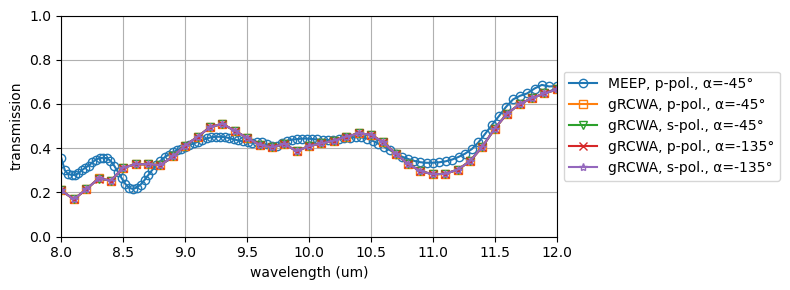

In [23]:
fig, ax = plt.subplots(1,1,figsize=(8,3))

# ax.plot(wl_range_tran_meep, tran_meep_res15, label='MEEP FDTD tran, p-pol., α=-45°')
ax.plot(wl_range_tran_meep, tran_meep_res40,  marker='o', fillstyle='none', label='MEEP, p-pol., α=-45°')

ax.plot(lam_range, res_p_pol_45deg[:,-1], marker='s', fillstyle='none', label='gRCWA, p-pol., α=-45°')
ax.plot(lam_range, res_s_pol_45deg[:,-1], marker='v', fillstyle='none', label='gRCWA, s-pol., α=-45°')

ax.plot(lam_range, res_p_pol_135deg[:,-1], marker='x', fillstyle='none', label='gRCWA, p-pol., α=-135°')
ax.plot(lam_range, res_s_pol_135deg[:,-1], marker='*', fillstyle='none', label='gRCWA, s-pol., α=-135°')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.legend()
ax.set_xlabel('wavelength (um)')
ax.set_ylabel('transmission')
ax.set_xlim([lam_range[0], lam_range[-1]])
ax.set_ylim([0, 1])
ax.grid()

fig.tight_layout()
# fig.savefig('MEEP_vs_gRCWA_tran.png', dpi=200)

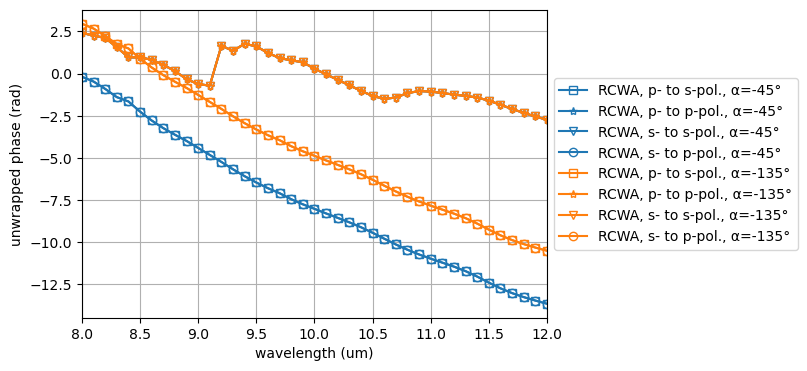

In [24]:
# phase unwrapping for 0-th order mode amplitudes

phase_p_pol_45deg_a_s0   = np.unwrap(np.angle(res_p_pol_45deg[:,0]))
phase_p_pol_45deg_a_p0   = np.unwrap(np.angle(res_p_pol_45deg[:,1]))
phase_s_pol_45deg_a_s0   = np.unwrap(np.angle(res_s_pol_45deg[:,0]))
phase_s_pol_45deg_a_p0   = np.unwrap(np.angle(res_s_pol_45deg[:,1]))
phase_p_pol_135deg_a_s0  = np.unwrap(np.angle(res_p_pol_135deg[:,0]))
phase_p_pol_135deg_a_p0  = np.unwrap(np.angle(res_p_pol_135deg[:,1]))
phase_s_pol_135deg_a_s0  = np.unwrap(np.angle(res_s_pol_135deg[:,0]))
phase_s_pol_135deg_a_p0  = np.unwrap(np.angle(res_s_pol_135deg[:,1]))


fig, ax = plt.subplots(1,1,figsize=(6,4))

clist = list(mcolors.TABLEAU_COLORS.values()) # default color palette

ax.plot(lam_range, phase_p_pol_45deg_a_s0,   color=clist[0], marker='s', fillstyle='none', label='RCWA, p- to s-pol., α=-45°')
ax.plot(lam_range, phase_p_pol_45deg_a_p0,   color=clist[0], marker='*', fillstyle='none', label='RCWA, p- to p-pol., α=-45°')
ax.plot(lam_range, phase_s_pol_45deg_a_s0,   color=clist[0], marker='v', fillstyle='none', label='RCWA, s- to s-pol., α=-45°')
ax.plot(lam_range, phase_s_pol_45deg_a_p0,   color=clist[0], marker='o', fillstyle='none', label='RCWA, s- to p-pol., α=-45°')
ax.plot(lam_range, phase_p_pol_135deg_a_s0,  color=clist[1], marker='s', fillstyle='none', label='RCWA, p- to s-pol., α=-135°')
ax.plot(lam_range, phase_p_pol_135deg_a_p0,  color=clist[1], marker='*', fillstyle='none', label='RCWA, p- to p-pol., α=-135°')
ax.plot(lam_range, phase_s_pol_135deg_a_s0,  color=clist[1], marker='v', fillstyle='none', label='RCWA, s- to s-pol., α=-135°')
ax.plot(lam_range, phase_s_pol_135deg_a_p0,  color=clist[1], marker='o', fillstyle='none', label='RCWA, s- to p-pol., α=-135°')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('wavelength (um)')
ax.set_ylabel('unwrapped phase (rad)')
ax.set_xlim([lam_range.min(), lam_range.max()])
ax.grid()

### phase: MEEP vs RCWA vs ref. APL

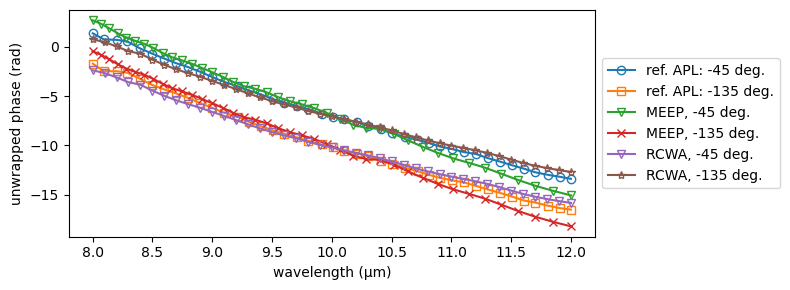

In [25]:
fig, ax = plt.subplots(1,1,figsize=(8,3))

ax.plot(man_wl_range, man_phase_45deg,  marker='o', fillstyle='none', label='ref. APL: -45 deg.')
ax.plot(man_wl_range, man_phase_135deg, marker='s', fillstyle='none', label='ref. APL: -135 deg.')

ax.plot(wl_range_phase_meep, phase_ex_45deg_meep -0.4, marker='v', fillstyle='none', label='MEEP, -45 deg.')
ax.plot(wl_range_phase_meep, phase_ex_135deg_meep-0.4, marker='x', fillstyle='none', label='MEEP, -135 deg.')

ax.plot(lam_range, phase_p_pol_45deg_a_s0 -2.2, marker='v', fillstyle='none', label='RCWA, -45 deg.')  # p- to s-pol.
ax.plot(lam_range, phase_p_pol_135deg_a_s0-2.2, marker='*', fillstyle='none', label='RCWA, -135 deg.') # p- to s-pol.

ax.set_xlabel('wavelength (μm)')
ax.set_ylabel('unwrapped phase (rad)')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()
# fig.savefig('MEEP_vs_gRCWA_phase.png', dpi=200)

## main: complex amplitude optimization with NLOpt

In [26]:
x_test = [2.4, 1.2, 2.8, 2.8] # lengths & widths of rect. pillars: [l1, w1, l2, w2], test value for debugging

gap = 2 # gap between rect. pillars
rot_angle_deg = -45 # angle of rotation for rect. pillars

lam = 12 # wavelength used in optimization
freq = 1./lam + 1j*1e-20 # frequency used in optimization

# transform of metaatom_grcwa()) function
# s0 -> (s0, p0)
get_amps_s0 = lambda x: metaatom_grcwa(x, gap=gap, rot_angle_deg=rot_angle_deg, freq=freq, planewave_params=S_wave, return_amps_only=True)
# p0 -> (s0, p0)
get_amps_p0 = lambda x: metaatom_grcwa(x, gap=gap, rot_angle_deg=rot_angle_deg, freq=freq, planewave_params=P_wave, return_amps_only=True)

get_amps_p0(x_test)

((0.09731152838615145+0.10996364792841211j),
 (-0.13275030291343953+0.30574242156957426j))

In [27]:
# target complex amplitude
amp_t = 1. * np.exp(1j*0.777*np.pi)

# function returning difference between complex amplitude calculated by amp_p0_to_s0() and a target amplitude 
amp_target_diff = lambda x: np.abs(get_amps_p0(x)[0] - amp_t) # !!! only s0 amp. is extracted
amp_target_diff(x_test)

1.0141831912706012

In [28]:
# definition of the corresponding gradient function
amp_target_diff_grad = grad(amp_target_diff)
amp_target_diff_grad(x_test, dxs)

array([-0.17681924, -0.22315138,  0.00374475, -0.28006655])

In [29]:
# objective functions definition for NLOpt: gradient based and non-gradient one

np_formatter = {'float_kind': lambda x: f'{x:6.3f}'} # formatter for printing NumPy arrays

def objective_func(x, gradn):
    
    global counter, fn_list, dxs
    
    fn = amp_target_diff(x)
    gradn[:] = amp_target_diff_grad(x, dxs)
    print(f'step no. {counter:2}: fn = {fn:.5f}, ' +\
          f'∇fn = {np.array2string(gradn, formatter=np_formatter)}, ' +\
          f'x = {np.array2string(x, formatter=np_formatter)}' )
    
    counter += 1
    fn_list.append(fn)
    
    return fn

def objective_func_nograd(x, gradn=0):
    
    global counter, fn_list
    
    fn = amp_target_diff(x)
    print(f'step no. {counter:2}: fn = {fn:.5f}, ' +\
          f'x = {np.array2string(x, formatter=np_formatter)}' )
    
    counter += 1
    fn_list.append(fn)
    
    return fn

In [30]:
opt_dict = {} # dictrionary for collecting data produced by different optimizers

In [31]:
# common parameters for NLOpt optimizers 

# lower & upper boundarieso for x = [l1, w1, l2, w2]
x_lb   = np.array([1.0, 1.0, 1.0, 1.0])
x_ub   = np.array([2.8, 2.8, 2.8, 2.8])

# x_init = x_lb + np.random.random(len(x_lb))*(x_ub-x_lb) # random x init value
x_init = [2.0, 2.3, 2.7, 2.6]

ndof = len(x_init) # degrees of freedom

### Method of Moving Asymptotes

In [32]:
# zeroing of global variables
counter = 0
fn_list = []

opt = nlopt.opt(nlopt.LD_MMA, ndof) # LD_MMA = Method of Moving Asymptotes
opt.set_lower_bounds(x_lb)
opt.set_upper_bounds(x_ub)

opt.set_xtol_rel(1e-5)
opt.set_maxeval(40) # max number of iterations

opt.set_min_objective(objective_func)
x_opt = opt.optimize(x_init)

step no.  0: fn = 1.12640, ∇fn = [-0.337  0.515  0.025 -0.191], x = [ 2.000  2.300  2.700  2.600]
step no.  1: fn = 0.91129, ∇fn = [-0.324  0.544  0.191  0.024], x = [ 2.176  2.069  2.680  2.717]
step no.  2: fn = 0.90368, ∇fn = [-0.258 -0.309 -0.346 -0.448], x = [ 2.682  1.494  2.254  2.579]
step no.  3: fn = 0.67848, ∇fn = [ 0.058  0.261  0.340  0.022], x = [ 2.800  1.745  2.520  2.800]
step no.  4: fn = 1.24532, ∇fn = [-0.097 -0.142 -0.321 -0.172], x = [ 2.353  1.040  1.778  2.523]
step no.  5: fn = 0.86590, ∇fn = [-0.238 -0.316 -0.512 -0.550], x = [ 2.694  1.442  2.171  2.754]
step no.  6: fn = 0.65694, ∇fn = [-0.183 -0.239  0.070 -0.222], x = [ 2.782  1.671  2.427  2.793]
step no.  7: fn = 0.64708, ∇fn = [-0.028 -0.025  0.119 -0.162], x = [ 2.800  1.724  2.411  2.800]
step no.  8: fn = 0.64531, ∇fn = [-0.041 -0.023  0.001 -0.217], x = [ 2.800  1.729  2.389  2.800]
step no.  9: fn = 0.65152, ∇fn = [ 0.034  0.324  0.114 -0.080], x = [ 2.800  1.788  2.385  2.800]
step no. 10: fn = 0.

In [33]:
opt_dict['LD_MMA'] = fn_list

amp_opt = get_amps_p0(x_opt)[0]
print(f'target amp. / phase: {np.abs(amp_t):.3f} / {np.angle(amp_t):.3f} rad',
      f'LD_MMA amp. / phase: {np.abs(amp_opt):.3f} / {np.angle(amp_opt):.3f} rad',
      f'phase mismatch: {np.abs(np.angle(amp_t)-np.angle(amp_opt)):.3f} rad',
      sep='\n')

target amp. / phase: 1.000 / 2.441 rad
LD_MMA amp. / phase: 0.355 / 2.437 rad
phase mismatch: 0.004 rad


### Low-storage BFGS

In [34]:
counter = 0
fn_list = []

opt = nlopt.opt(nlopt.LD_LBFGS, ndof) # LD_LBFGS = Low-storage BFGS
opt.set_lower_bounds(x_lb)
opt.set_upper_bounds(x_ub)

opt.set_xtol_rel(1e-5)
opt.set_maxeval(40) # max number of iterations

opt.set_min_objective(objective_func)
x_opt = opt.optimize(x_init)

step no.  0: fn = 1.12640, ∇fn = [-0.337  0.515  0.025 -0.191], x = [ 2.000  2.300  2.700  2.600]
step no.  1: fn = 0.81914, ∇fn = [-0.485 -0.271  0.153 -0.087], x = [ 2.337  1.785  2.675  2.791]
step no.  2: fn = 0.80736, ∇fn = [-0.466 -0.254  0.167 -0.096], x = [ 2.363  1.778  2.669  2.800]
step no.  3: fn = 0.68210, ∇fn = [-0.110 -0.276  0.171 -0.218], x = [ 2.800  1.596  2.506  2.800]
step no.  4: fn = 1.01363, ∇fn = [ 0.066 -0.175  0.067 -0.137], x = [ 2.800  2.639  2.800  2.800]
step no.  5: fn = 0.67160, ∇fn = [-0.034 -0.034  0.261 -0.093], x = [ 2.800  1.678  2.529  2.800]
step no.  6: fn = 1.20608, ∇fn = [ 0.335  1.200  0.094  0.001], x = [ 2.800  2.076  1.417  2.800]
step no.  7: fn = 0.64926, ∇fn = [-0.032 -0.045  0.154 -0.153], x = [ 2.800  1.713  2.430  2.800]
step no.  8: fn = 0.67380, ∇fn = [-0.009  0.083 -0.554 -0.418], x = [ 2.800  1.797  2.263  2.800]
step no.  9: fn = 0.64494, ∇fn = [-0.025 -0.005 -0.031 -0.208], x = [ 2.800  1.741  2.373  2.800]
step no. 10: fn = 0.

RuntimeError: nlopt failure

In [35]:
opt_dict['LD_LBFGS'] = fn_list

amp_opt = get_amps_p0(x_opt)[0]
print(f'target   amp. / phase: {np.abs(amp_t):.3f} / {np.angle(amp_t):.3f} rad',
      f'LD_LBFGS amp. / phase: {np.abs(amp_opt):.3f} / {np.angle(amp_opt):.3f} rad',
      f'phase mismatch: {np.abs(np.angle(amp_t)-np.angle(amp_opt)):.3f} rad',
      sep='\n')

target   amp. / phase: 1.000 / 2.441 rad
LD_LBFGS amp. / phase: 0.355 / 2.437 rad
phase mismatch: 0.004 rad


### COBYLA

In [36]:
counter = 0
fn_list = []

opt = nlopt.opt(nlopt.LN_COBYLA, ndof) # LN_COBYLA = Constrained Optimization BY Linear Approximations
opt.set_lower_bounds(x_lb)
opt.set_upper_bounds(x_ub)

opt.set_initial_step(0.1*np.ones(len(x_init)))

opt.set_xtol_rel(1e-5)
opt.set_maxeval(60) # max number of iterations

opt.set_min_objective(objective_func_nograd)
x_opt = opt.optimize(x_init)

step no.  0: fn = 1.12640, x = [ 2.000  2.300  2.700  2.600]
step no.  1: fn = 1.08881, x = [ 2.100  2.300  2.700  2.600]
step no.  2: fn = 1.10932, x = [ 2.100  2.400  2.700  2.600]
step no.  3: fn = 1.08165, x = [ 2.100  2.300  2.600  2.600]
step no.  4: fn = 1.06243, x = [ 2.100  2.300  2.600  2.700]
step no.  5: fn = 1.00402, x = [ 2.179  2.257  2.585  2.740]
step no.  6: fn = 0.96225, x = [ 2.266  2.222  2.573  2.773]
step no.  7: fn = 0.91486, x = [ 2.341  2.164  2.553  2.800]
step no.  8: fn = 0.85069, x = [ 2.383  2.075  2.537  2.800]
step no.  9: fn = 0.78472, x = [ 2.361  1.978  2.528  2.800]
step no. 10: fn = 0.76167, x = [ 2.369  1.879  2.518  2.800]
step no. 11: fn = 0.81716, x = [ 2.271  1.857  2.513  2.800]
step no. 12: fn = 0.77108, x = [ 2.368  1.874  2.551  2.789]
step no. 13: fn = 0.72190, x = [ 2.461  1.854  2.488  2.800]
step no. 14: fn = 0.69538, x = [ 2.546  1.806  2.465  2.800]
step no. 15: fn = 0.70644, x = [ 2.538  1.757  2.378  2.800]
step no. 16: fn = 0.6987

In [37]:
opt_dict['LN_COBYLA'] = fn_list

amp_opt = get_amps_p0(x_opt)[0]
print(f'target    amp. / phase: {np.abs(amp_t):.3f} / {np.angle(amp_t):.3f} rad',
      f'LN_COBYLA amp. / phase: {np.abs(amp_opt):.3f} / {np.angle(amp_opt):.3f} rad',
      f'phase mismatch: {np.abs(np.angle(amp_t)-np.angle(amp_opt)):.3f} rad',
      sep='\n')

target    amp. / phase: 1.000 / 2.441 rad
LN_COBYLA amp. / phase: 0.355 / 2.453 rad
phase mismatch: 0.012 rad


### optimizers comparison

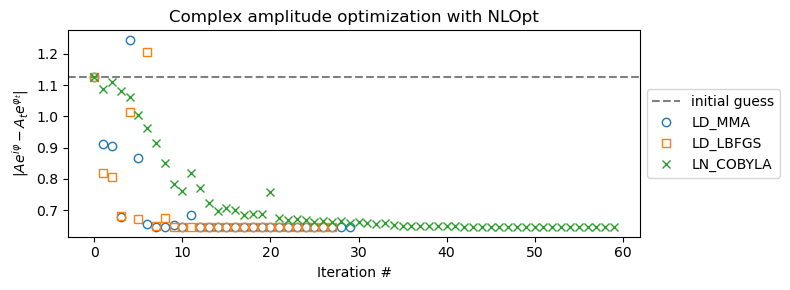

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(8,3))
markers = ['o', 's', 'x']

ax.axhline(opt_dict['LD_MMA'][0], linestyle='--', color='gray', label='initial guess')

for (name, data), m in zip(opt_dict.items(),markers) :
    
    ax.plot(data, marker=m, linestyle='none', fillstyle='none', label=name)

# ax.set_yscale('log')

ax.set_title('Complex amplitude optimization with NLOpt')
ax.set_xlabel('Iteration #')
ax.set_ylabel(r'$|Ae^{i\varphi}-A_t e^{\varphi_{t}}|$')

# ax.set_ylim([1e-4, np.pi])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
# fig.savefig('RCWA_optimization.png', dpi=200)